# Potential and current in the "Van der Pauw" square

A common simple geometry for Hall-effect measurements is the Van der Pauw square. This has the advantage that a mm-sized square can be cut directly out of a wafer and measured, assuming we have some way of attaching leads to the corners. Both of these require manual dexterity.

Another advantage is that parallel conduction paths through the substrate maintain the same geometry as the QW, rather than being able to go around a mesa-etched device.

However, the measurement and the analysis is more complicated.

Installation instructions for fenics (legacy) can be found at https://fenicsproject.org/download/archive/


In [1]:
#! /usr/bin/env python3
# based on demo_mixed-poisson.py
# but see sections 4.1 and 4.2 in the tutorial pdf
# and https://fenicsproject.discourse.group/t/pde-system-simple-example/1550/2

# now also section 4.3 and https://fenicsproject.org/docs/dolfin/2019.1.0/python/demos/tensor-weighted-poisson/documentation.html

# Installation instructions for fenics: https://fenicsproject.org/download/archive/
# This script works with version 2019.1.0

from dolfin import *
import matplotlib.pyplot as plt
import numpy as np

We will define a square of semiconductor material and then specify a square contact at each of the corners (as high-conductivity regions). To measure $\rho_{xx}$ we apply the current along one side of the square and measure the potential difference between the two corners on the other side. To measure $\rho_{xy}$ we apply the current diagonally across the square and measure the potential difference between the other two opposite corners. In the code these are "configuration 1".

In order to correct for the square not being actually square, we need to repeat the $\rho_{xx}$ and $\rho_{xy}$ measurements with the current perpendicular to these cases ("configuration 2").

The code here performs one measurement at a time.

Two-terminal resistance 148.62 Ohm
... at B = 0.00 T:
Hall coefficient: 891.74 Ohm/T
rho_xx = 148.62 Ohm/sq	rho_xy = 0.00 Ohm
0.00	148.62	148.62	0.00	891.74	7.0000e+15	6.0000
Solving linear variational problem.
4.063805709389008e-12
3.6298124932445184e-05
Saved function f_458-0 (a Function) to file fenics-VdP01_phi.xyz in xd3d xyz format.
Saved function f_485 (a Function) to file fenics-VdP01_Jx.xyz in xd3d xyz format.
Saved function f_502 (a Function) to file fenics-VdP01_Jy.xyz in xd3d xyz format.


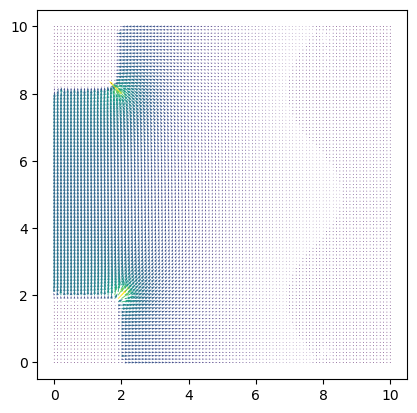

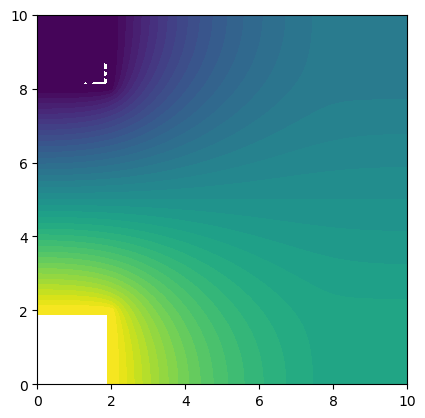

In [12]:
BarLength = 10.0
BarWidth = 10.0

ContactSize = 2.0

YLead1 = 0.0
YLead2 = YLead1+ContactSize

YLead3 = BarWidth-ContactSize
YLead4 = BarWidth

XLead1 = 0.0
XLead2 = XLead1+ContactSize

XLead3 = BarLength-ContactSize
XLead4 = BarLength

ResFactor = 1

LPoints = ResFactor*100
WPoints = ResFactor*100

ResL = BarLength/LPoints
ResW = BarWidth/WPoints

mu = 6 # m2/Vs
ns = 7e15 # m-2
qe = 1.602e-19 # C

B = 0.00 # T

measH = False # Hall or resistance measurement?
conf = 1 # configuration 1 or 2

cond0 = ns*qe*mu
rho0 = 1/cond0
#print('Zero-field conductivity: {:.2e}'.format(cond0))
#print('Zero-field resistivity: {:.2f} Ohm/sq'.format(rho0))

R2 = rho0*BarLength/BarWidth
RH = 1/(qe*ns)
print('Two-terminal resistance {:.2f} Ohm'.format(R2))
print('... at B = {:.2f} T:'.format(B))
print('Hall coefficient: {:.2f} Ohm/T'.format(RH))
print('rho_xx = {:.2f} Ohm/sq\trho_xy = {:.2f} Ohm'.format(rho0,B*RH))

print('{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.4e}\t{:.4f}'.format(B,R2,rho0,B*RH,RH,ns,mu))

# Create mesh
mesh = RectangleMesh(Point(0.0, 0.0), Point(BarLength, BarWidth), LPoints, WPoints, "right/left")


el_scalar = FiniteElement("Lagrange", mesh.ufl_cell(), 1)  # potential
el_vector = VectorElement("Lagrange", mesh.ufl_cell(), 2)  # current density
el = MixedElement([el_scalar, el_vector])
Vmixed = FunctionSpace(mesh, el)
v, tau = TestFunctions(Vmixed)
u, sigma = TrialFunctions(Vmixed)

phi = Vmixed.sub(0)
J = Vmixed.sub(1)

# Semiconductor
csemixx = cond0/(1+mu*mu*B*B)
csemixy = cond0*mu*B/(1+mu*mu*B*B)
# Voltage probes
ccontact = Constant(1000.0)
ccontactH = Constant(0.0)
f = Constant(0.0)

class Sxx(UserExpression):
    def set_cond_values(self, csemixx, ccontact):
        self.csemixx, self.ccontact = csemixx, ccontact

    def eval(self, value, x):
        if x[0] > XLead1 + ResL and x[0] < XLead2 and ((x[1] > YLead1 + ResW and x[1] < YLead2) or (x[1] > YLead3 and x[1] < YLead4 - ResW)):
            value[0] = self.ccontact

        elif x[0] > XLead3 and x[0] < XLead4 - ResL and ((x[1] > YLead1 + ResW and x[1] < YLead2) or (x[1] > YLead3 and x[1] < YLead4 - ResW)):
            value[0] = self.ccontact

        else:
            value[0] = self.csemixx

class Sxy(UserExpression):
    def set_cond_values(self, csemixy, ccontactH):
        self.csemixy, self.ccontactH = csemixy, ccontactH

    def eval(self, value, x):
        if x[0] > XLead1 + ResL and x[0] < XLead2 and ((x[1] > YLead1 + ResW and x[1] < YLead2) or (x[1] > YLead3 and x[1] < YLead4 - ResW)):
            value[0] = self.ccontactH

        elif x[0] > XLead3 and x[0] < XLead4 - ResL and ((x[1] > YLead1 + ResW and x[1] < YLead2) or (x[1] > YLead3 and x[1] < YLead4 - ResW)):
            value[0] = self.ccontactH

        else:
            value[0] = self.csemixy

#Initialize conductivity
condxx = Sxx(mesh, degree=0)
condxy = Sxy(mesh, degree=0)
condxx.set_cond_values(csemixx,ccontact)
condxy.set_cond_values(csemixy,ccontactH)

cond = as_matrix(((condxx,condxy),(-condxy,condxx)))

#condSpace = FunctionSpace(mesh,'DG',0)
#condPlot = project(condxx,condSpace)
#plot(condPlot)
#plt.show()
#condPlot = project(condxy,condSpace)
#plot(condPlot)
#plt.show()

#cond = as_matrix(((S[0],S[1]),(-S[1],S[0])))

F = dot(cond*grad(u) + sigma, tau) * dx + dot(sigma, grad(v)) * dx - f * v * dx

# Define function G such that G \cdot n = g
class BoundarySource(UserExpression):
    def __init__(self, mesh, **kwargs):
        self.mesh = mesh
        super().__init__(**kwargs)
    def eval_cell(self, values, x, ufc_cell):
        cell = Cell(self.mesh, ufc_cell.index)
        n = cell.normal(ufc_cell.local_facet)
        g = 0.0
        values[0] = g*n[0]
        values[1] = g*n[1]
    def value_shape(self):
        return (2,)

G = BoundarySource(mesh, degree=2)

# Define essential boundary
def boundary(x, on_boundary):
    return on_boundary # (x[1] < 0.0 + ResW or x[1] > BarWidth - ResW)

bc_Sides = DirichletBC(J, G, boundary, method='pointwise')

# Define current drain and source

VD = 0.001 # applied drain voltage

u_D = Constant(VD)
u_S = Constant(0.000)

# define all four contacts as possible source or drain:

def boundary_1(x, on_boundary):
    return (x[0] < XLead2) and (x[1] < YLead2)

def boundary_2(x, on_boundary):
    return (x[0] < XLead2) and (x[1] > YLead3)

def boundary_3(x, on_boundary):
    return (x[0] > XLead3) and (x[1] > YLead3)

def boundary_4(x, on_boundary):
    return (x[0] > XLead3) and (x[1] < YLead2)

# set which contacts are source and drain

if measH:
    if conf==1:
        bc_D = DirichletBC(phi, u_D, boundary_1, method='pointwise')
        bc_S = DirichletBC(phi, u_S, boundary_3, method='pointwise')
        
    else:
        bc_D = DirichletBC(phi, u_D, boundary_2, method='pointwise')
        bc_S = DirichletBC(phi, u_S, boundary_4, method='pointwise')

else:
    if conf==1:
        bc_D = DirichletBC(phi, u_D, boundary_1, method='pointwise')
        bc_S = DirichletBC(phi, u_S, boundary_2, method='pointwise')

    else:
        bc_D = DirichletBC(phi, u_D, boundary_1, method='pointwise')
        bc_S = DirichletBC(phi, u_S, boundary_4, method='pointwise')


# Collect boundary conditions

bc = [bc_D, bc_S, bc_Sides]

u = Function(Vmixed)

solve(lhs(F) == rhs(F), u, bc)

phi, J = u.split()

# calculate total current flux in x and y directions

total_current_x = assemble(J[0]*dx)
total_current_y = assemble(J[1]*dx)
print(total_current_x)
print(total_current_y)

plt.figure('current density')
plot(J)

xhat = as_vector((1.0,0.0))
yhat = as_vector((0.0,1.0))
Jx = dot(J, xhat)
Jy = dot(J, yhat)
Jx_proj = project(Jx, FunctionSpace(mesh, el_scalar))
Jy_proj = project(Jy, FunctionSpace(mesh, el_scalar))

#plt.figure('current density in x direction')
#plot(Jx)
#plt.figure('current density in y direction')
#plot(Jy)

plt.figure('potential')
plot(phi)

# Save potential
phi_file = File("fenics-VdP01_phi.xyz")
phi_file << phi

# Save J
#J_file = File("bar08-2_J.pvd")
#J_file << J

# Save Jx and Jy
Jx_file = File("fenics-VdP01_Jx.xyz")
Jy_file = File("fenics-VdP01_Jy.xyz")
Jx_file << Jx_proj
Jy_file << Jy_proj

plt.show()

In [11]:
qe = 1.602e-19 # C

phi_file = 'fenics-VdP01_phi000000.xyz'
Jx_file = 'fenics-VdP01_Jx000000.xyz'
Jy_file = 'fenics-VdP01_Jy000000.xyz'

phix, phiy, phival = np.loadtxt(phi_file, unpack=True)
Jxx, Jxy, Jxval = np.loadtxt(Jx_file, unpack=True)
Jyx, Jyy, Jyval = np.loadtxt(Jy_file, unpack=True)

f = 1.0 # non-square factor
VdP = 4.53236 # pi/ln(2)

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def getPotential(position):
    #print(position)
    possiblex = np.where(np.abs(phix - position[0])<0.5*ResL)
    #print(possiblex[0])
    possibley = np.where(np.abs(phiy - position[1])<0.5*ResW)
    #print(possibley[0])
    onlyxy = np.intersect1d(possiblex,possibley)
    return phival[onlyxy]

def getCurrentX(position):
    #print(position)
    line = np.where(np.abs(Jxx - position)<0.5*ResL)
    Jxline = Jxval[line]
    Jxposy = Jxy[line]
    #print(Jxposy)
    Itot = np.trapz(Jxline,x=Jxposy)
    return Itot

def getCurrentY(position):
    #print(position)
    line = np.where(np.abs(Jyy - position)<0.5*ResW)
    Jyline = Jyval[line]
    Jyposx = Jyx[line]
    #print(Jyposx)
    Itot = np.trapz(Jyline,x=Jyposx)
    return Itot

probex12 = 0.5*(XLead1+XLead2)
probex34 = 0.5*(XLead3+XLead4)

probey14 = 0.5*(YLead1+YLead2)
probey23 = 0.5*(YLead3+YLead4)


# voltage probe positions:
probe1 = np.array((probex12,probey14))
probe2 = np.array((probex12,probey23))
probe3 = np.array((probex34,probey23))
probe4 = np.array((probex34,probey14))

V1 = getPotential(probe1)[0]
V2 = getPotential(probe2)[0]
V3 = getPotential(probe3)[0]
V4 = getPotential(probe4)[0]

print('V1      \tV2      \tV3      \tV4      ')
print('{:.2e}\t{:.2e}\t{:.2e}\t{:.2e}'.format(V1,V2,V3,V4))

print('length/width = {:.4f}'.format(BarLength/BarWidth))

# current integration line position in x:
currentx = 0.5*BarLength
currenty = 0.5*BarWidth

IdrainX = getCurrentX(currentx)
IdrainY = getCurrentY(currenty)
Idrain = np.sqrt(IdrainX**2+IdrainY**2)
print('Id(x)    \tId(y)')
print('{:.2e}\t{:.2e}'.format(IdrainX,IdrainY))

R2 = VD/Idrain

print('Two-terminal resistance {:.2f} Ohm'.format(R2))

if measH is True:
    # Hall measurement
    Vy = V4-V2
    rhoxy = Vy/Idrain
    print('rho_xy = {:.2f} Ohm'.format(rhoxy))
    if B != 0.0:
        RH = rhoxy/B
        ns = 1/(qe*RH)
        print('... at B = {:.2f} T:'.format(B))
        print('Hall coefficient: {:.2f} Ohm/T'.format(RH))
        print('Hall sheet density: {:.4e} cm-2'.format(ns*1e-4))

else:
    # Resistance measurement
    if conf==1:
        Vx = V4-V3
        print('R_|| = {:.2f} Ohm'.format(Vx/Idrain))
    
    else:
        Vs = V2-V3
        print('R_= = {:.2f} Ohm'.format(Vx/Idrain))

    rhoxx = f*VdP*Vx/Idrain
    print('rho_xx = {:.2f} Ohm/sq'.format(rhoxx))

V1      	V2      	V3      	V4      
1.00e-03	0.00e+00	8.39e-04	9.10e-04
length/width = 1.0000
Id(x)    	Id(y)
1.01e-11	1.94e-06
Two-terminal resistance 516.72 Ohm
R_|| = 36.53 Ohm
rho_xx = 165.55 Ohm/sq


For measuring $\rho_{xx}$, the value of $V_x / I_{\textrm{drain}}$ is not $\rho_{xx}$, but we will call the "configuration 1" result $R_{||}$ and the "configuration 2" result $R_{=}$. If these two results are not equal, it signifies that the square is not truly square. The correction factor $f(x)$ is given (implictly) by
$$\frac{x-1}{x+1} = \frac{f}{\ln 2}\textrm{arccosh} \left[ \frac{1}{2}\exp\left(\frac{\ln 2}{f}\right)\right]$$
so that 
$$\rho_{xx} = \frac{\pi}{\ln 2}\frac{R_{||}+R_{=}}{2}f\left(\frac{R_{||}}{R_{=}}\right)$$

For a square sample, $f=1$ and the factor $\pi/\ln 2 = 4.532$.

There are no such complications with $\rho_{xy}$, we just average the two configurations. However, the contacts must be small compared to the square.